In [2]:
import os
import lmdb
import caffe
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [22]:
from snntoolbox.io_utils.common import to_categorical

path_to_dataset = '/home/rbodo/.snntoolbox/Datasets/roshambo'

lmdb_env = lmdb.open(path_to_dataset)
lmdb_txn = lmdb_env.begin()
lmdb_cursor = lmdb_txn.cursor()

x_test = []
y_test = []

for key, value in lmdb_cursor:
    datum = caffe.proto.caffe_pb2.Datum()
    datum.ParseFromString(value)
    x_test.append(caffe.io.datum_to_array(datum) / 255.)
    y_test.append(int(datum.label))

y_test = to_categorical(y_test, 4)

np.savez_compressed(os.path.join(path_to_dataset, 'x_norm'), np.array(x_test, dtype='float32'))
np.savez_compressed(os.path.join(path_to_dataset, 'x_test'), np.array(x_test, dtype='float32'))
np.savez_compressed(os.path.join(path_to_dataset, 'y_test'), np.array(y_test, dtype='float32'))

{'0': 'paper', '1': 'scissors', '3': 'background', '2': 'rock'}
Class boundaries: [ 4997  7435 11633 15850]


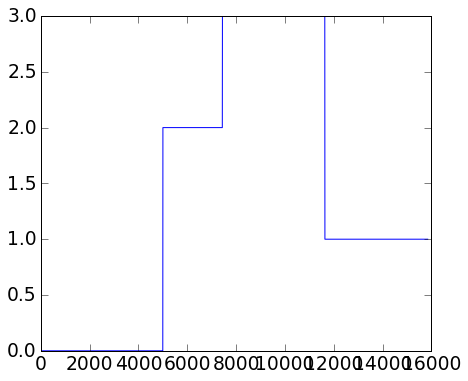

In [22]:
plt.plot(y_test)
class_label_idx = {'0': 'paper', '1': 'scissors', '2': 'rock', '3': 'background'}
print(class_label_idx)
class_sizes = [len(np.nonzero(np.array(y_test)==i)[0]) for i in [0, 2, 3, 1]]
print('Class boundaries: {}'.format(np.cumsum(class_sizes)))

[ 1.  0.  0.  0.]


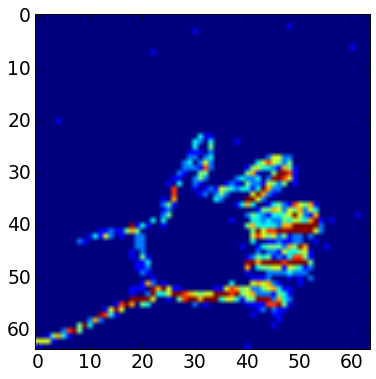

In [24]:
plt.imshow(x_test[0][0])
print(y_test[0])

In [3]:
path = '/home/rbodo/.snntoolbox/data/roshambo'
prototxt = os.path.join(path, 'NullHop.prototxt')
caffemodel = os.path.join(path, 'NullHop.caffemodel')
model = caffe.Net(prototxt, 1, weights=caffemodel)

In [ ]:
# To be executed in the terminal running python2

import sys
sys.path.remove('/mnt/2646BAF446BAC3B9/Repositories/caffe/python')
sys.path.append('/mnt/2646BAF446BAC3B9/Repositories/caffe_lp/python')
import caffe
from caffe.quantization.net_descriptor import net_prototxt
net = net_prototxt()
caffe_root = '/mnt/2646BAF446BAC3B9/Repositories/caffe_lp/'
weight_dir = '/home/rbodo/Downloads/'#'/home/rbodo/.snntoolbox/data/roshambo/'  # Location of caffemodel
save_dir = '/home/rbodo/.snntoolbox/data/roshambo/standard_caffe/'
model_dir = 'examples/low_precision/'  # Put prototxt file there, and append '_deploy' to filename.
net_descr = net.extract('NullHop', caffe_root=caffe_root, model_dir=model_dir, weight_dir=weight_dir)
net.create('NullHop', net_descr, lp=False, deploy=True, caffe_root=caffe_root, model_dir=model_dir, save_dir=save_dir)
# In output file, remove dropout layer (change 'bottom' parameter of following layer) and adapt input layer
net1 = caffe.Net(caffe_root+model_dir+'NullHop_deploy.prototxt', 1, weights=weight_dir+'NullHop/NullHop.caffemodel')
net2 = caffe.Net(save_dir+'NullHop_deploy.prototxt', 1)
for k1, k2 in zip(net1.params.keys(), net2.params.keys()):
    net2.params[k2][0] = net1.params[k1][1]
    net2.params[k2][1] = net1.params[k1][3]
net2.save(save_dir+'NullHop.caffemodel')